In [65]:
import os
import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm

In [2]:
filename = "Raw Data/touchevent.csv"

In [3]:
def decoupling_time(r):
    '''
    This will output in this format: 1970-08-22 19:25:00 
    '''
    s = str(r)
    year, month, day, hour, minute, second = s[:4], s[4:6], s[6:8], s[8:10], s[10:12], s[12:14]
    
    return '-'.join([year, month, day]) + ' ' + ':'.join([hour, minute, second])
#decoupling_time(20201117235750093)

In [13]:
final_data = pd.DataFrame()

row_count = 5000000
c = 0
for chunk in tqdm(pd.read_csv(filename, chunksize=row_count)): 
    #deep copy 
    temp = pd.DataFrame(columns=['experimentid', 'userid'])
    temp = chunk[['experimentid', 'userid']]
    
    #turning now time from raw to machine readable ; #every minute has a specific count                                         
    shortened_times = pd.to_datetime(chunk['timestamp'].apply(
        decoupling_time), yearfirst=True).dt.floor('min')
    temp.insert(2, 'timestamp', shortened_times)
    #attenzione: il conteggio potrebbe essere meglio rappresentato
    # da una misura di massimo un numero di tocchi al secondo, oltre 
    #la quale si è outliers o c'è un errore nei dati; quando viene 
    # portato al minuto, la somma può essere divisa per secondi (60)
    
    #grouping 
    df_grouped = temp.groupby(['userid', 'experimentid', 'timestamp']).size()                                         
    df_grouped = df_grouped.reset_index(name='touches')
    
    #appending to a global df
    final_data = pd.concat([final_data, df_grouped], ignore_index=True) 
    #c += 1  #safety loop before the kernel dies out
    #if c == 100:
    #    break

12it [02:33, 12.76s/it]/tmp/ipykernel_12967/4030786520.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  shortened_times = pd.to_datetime(chunk['timestamp'].apply(
26it [05:28, 12.62s/it]


<Axes: ylabel='Frequency'>

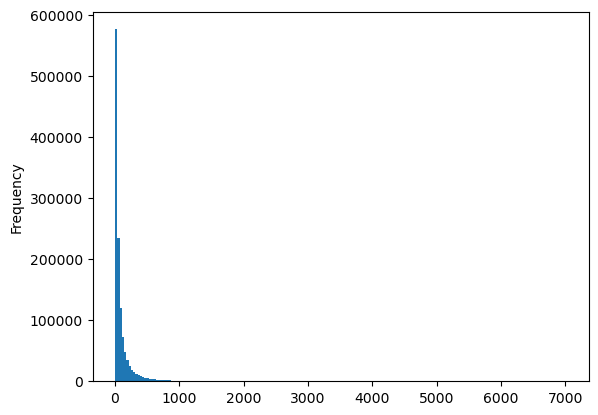

In [51]:
final_data.touches.plot.hist(bins=200)  

# Some methodological reflections. 
In order to get in one minute 7000 touches you need to tap the screen on average 117 times each second. Which is just impossible. Consider this: 
- the fastest finger tapping rate was set by Japanese musician Kaoru Watanabe in 2014. He achieved a rate of 13.36 taps per second = 801 per minute.
- Prabhshish Singh (at 13) accurately typed letters from A to Z on a mobile phone in just 3 seconds and 44 milliseconds, as confirmed on August 29, 2022, making it about 7.5 touches each second, making it  453 per minute. 

I'd say not all users here must be world-record breakers, so for now at most 500 touches per minute is a roof that doesn't exclude gamers, but further inspection with statistics will be done.

In [109]:
z = np.abs(stats.zscore(final_data['touches']))
threshold = 3  #this is the typical chosen score for outliers
outliers = final_data[z > threshold]
#print("User IDs with outlier observations:\n", np.sort(outliers.userid.unique()))
print("Outliers belong to:",outliers.userid.unique().shape[0], "out of", final_data.userid.unique().shape[0], 'of the users')
print("Outliers are", outliers.shape[0], "out of", final_data.shape[0], ". So:",  str(round(outliers.shape[0]/ final_data.shape[0]*100, 2))+'%')


Outliers belong to: 115 out of 201 of the users
Outliers are 21712 out of 1235560 . So: 1.76%


In [61]:
final_data

,userid,experimentid,timestamp,touches
0,1,wenetItaly,2020-11-22 00:00:00,12
1,1,wenetItaly,2020-11-22 00:01:00,12
2,1,wenetItaly,2020-11-22 00:02:00,20
3,1,wenetItaly,2020-11-22 00:03:00,28
4,1,wenetItaly,2020-11-22 00:04:00,17
...,...,...,...,...
1235555,260,wenetItaly,2020-12-06 20:58:00,29
1235556,260,wenetItaly,2020-12-06 21:38:00,83
1235557,260,wenetItaly,2020-12-06 21:39:00,67
1235558,260,wenetItaly,2020-12-06 21:40:00,120
